# Import Libs

In [15]:
import kagglehub
import pandas as pd
import numpy as np
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import gc
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device.type

'cuda'

# Load Data

In [2]:
def gather_image_mask_paths(base_path, label):
    """
    base_path: e.g. "COVID" directory path
    label: integer or string class label
    Returns:
        image_paths (list of str)
        mask_paths (list of str)
        labels (list of int or str)
    """
    images_dir = os.path.join(base_path, "images")
    masks_dir = os.path.join(base_path, "masks")

    # Collect all valid image filenames
    image_filenames = [
        f for f in os.listdir(images_dir)
        if f.lower().endswith((".png", ".jpg", ".jpeg")) and f.split("/")[-1].split("-")[-1].split(".")[0].isnumeric() and 101 <= int(f.split("/")[-1].split("-")[-1].split(".")[0]) <= 600
    ]

    image_paths = []
    mask_paths = []
    labels = []

    for filename in image_filenames:
        image_path = os.path.join(images_dir, filename)
        mask_path = os.path.join(masks_dir, filename)  # same name in masks/
        image_paths.append(image_path)
        mask_paths.append(mask_path)
        labels.append(label)

    return image_paths, mask_paths, labels

In [3]:
def load_numpy_data(image_paths, mask_paths, labels):
    data = []
    for image_path, mask_path, label in tqdm(zip(image_paths, mask_paths, labels), total=len(image_paths)):
        with Image.open(image_path) as img:
            img_arr = np.array(img.convert("RGB"))  
            # shape might be (height, width, 3)
        
        # Load mask
        with Image.open(mask_path) as msk:
            mask_arr = np.array(msk.convert("L")) 
            # or "RGB" if masks are color-coded
            # Typically masks are single-channel
        
        data.append((img_arr, mask_arr, label))
        
    return data

In [4]:
kaggle_cache_path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")
full_path = os.path.join(kaggle_cache_path, "COVID-19_Radiography_Dataset")
lung_opacity_path = os.path.join(full_path, "Lung_Opacity")
normal_path = os.path.join(full_path, "Normal")
viral_pneumonia_path = os.path.join(full_path, "Viral Pneumonia")
covid_path = os.path.join(full_path, "COVID")
lung_metadata = pd.read_excel(os.path.join(full_path, "Lung_Opacity.metadata.xlsx"))
normal_metadata = pd.read_excel(os.path.join(full_path, "Normal.metadata.xlsx"))
viral_pneumonia_metadata = pd.read_excel(os.path.join(full_path, "Viral Pneumonia.metadata.xlsx"))
covid_metadata = pd.read_excel(os.path.join(full_path, "COVID.metadata.xlsx"))

COVID_LABEL = 0
NORMAL_LABEL = 1
VIRAL_PNEUMONIA_LABEL = 2
LUNG_OPACITY_LABEL = 3

all_image_paths = []
all_mask_paths = []
all_labels = []

covid_images, covid_masks, covid_labels = gather_image_mask_paths(covid_path, COVID_LABEL)
all_image_paths.extend(covid_images)
all_mask_paths.extend(covid_masks)
all_labels.extend(covid_labels)

normal_images, normal_masks, normal_labels = gather_image_mask_paths(normal_path, NORMAL_LABEL)
all_image_paths.extend(normal_images)
all_mask_paths.extend(normal_masks)
all_labels.extend(normal_labels)

vp_images, vp_masks, vp_labels = gather_image_mask_paths(viral_pneumonia_path, VIRAL_PNEUMONIA_LABEL)
all_image_paths.extend(vp_images)
all_mask_paths.extend(vp_masks)
all_labels.extend(vp_labels)

lo_images, lo_masks, lo_labels = gather_image_mask_paths(lung_opacity_path, LUNG_OPACITY_LABEL)
all_image_paths.extend(lo_images)
all_mask_paths.extend(lo_masks)
all_labels.extend(lo_labels)

print("Total images:", len(all_image_paths))

100%|██████████| 778M/778M [00:23<00:00, 35.1MB/s] 

Extracting files...


Total images: 2000


2000 images, masks, and labels - 500 each of COVID, Normal, Viral Pneumonia, and Lung Opacity

In [5]:
data = load_numpy_data(all_image_paths, all_mask_paths, all_labels)

# Split data into train and test
train, test = train_test_split(data, test_size=0.2, random_state=42)

X_images = np.array([item[0] for item in train])
X_masks = np.array([item[1] for item in train])
y_labels = np.array([item[2] for item in train])

len(X_images), len(X_masks), len(y_labels)

100%|██████████| 2000/2000 [00:02<00:00, 722.82it/s]


(1600, 1600, 1600)

In [6]:
# PCA
pca = PCA(n_components=3)
X_images_flat = X_images.reshape(X_images.shape[0], -1)
X_images_pca = pca.fit_transform(X_images_flat)
X_images_pca.shape

(1600, 3)

In [14]:
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.2754731  0.14772652 0.06291951]


In [18]:
# Compute global mean per feature
mean_vector = np.mean(X_images_flat, axis=0)
# Compute MSE if you replaced every sample with the global mean
naive_mse = mean_squared_error(X_images_flat, 
                               np.tile(mean_vector, (X_images_flat.shape[0], 1)))

print("Naive Baseline MSE (all samples = mean):", naive_mse)

Naive Baseline MSE (all samples = mean): 2254.6729871070725


In [16]:
# Reconstruct back to original space
X_images_reconstructed = pca.inverse_transform(X_images_pca)

# Compute MSE (reconstruction error)
mse = mean_squared_error(X_images_flat, X_images_reconstructed)
print("Reconstruction MSE:", mse)

Reconstruction MSE: 1158.6333190304342


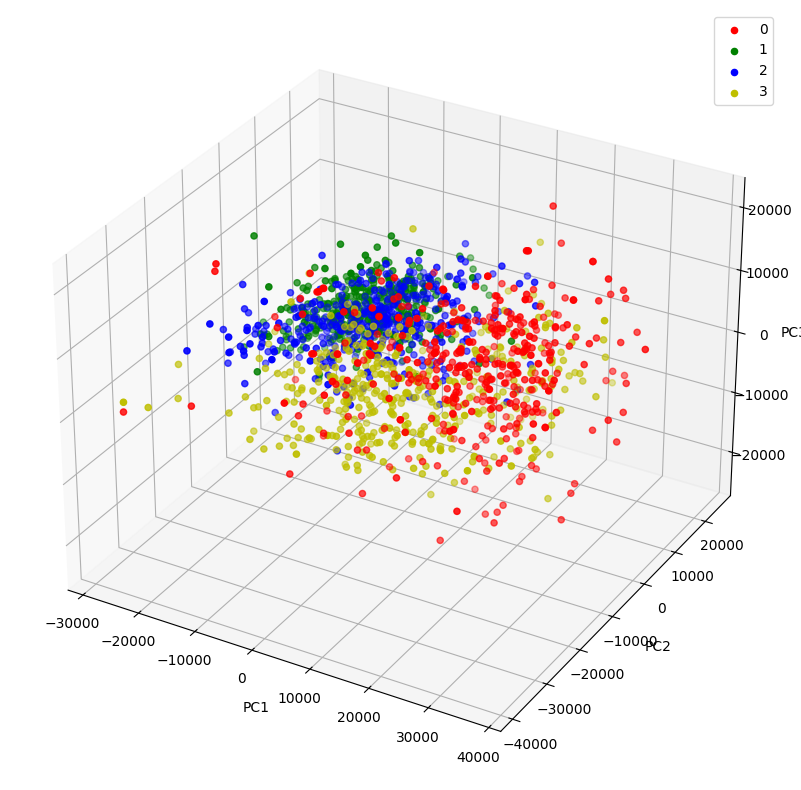

In [7]:
# plot PCA
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'y']
for i in range(4):
    ax.scatter(X_images_pca[y_labels == i, 0], X_images_pca[y_labels == i, 1], X_images_pca[y_labels == i, 2], c=colors[i], label=str(i))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()

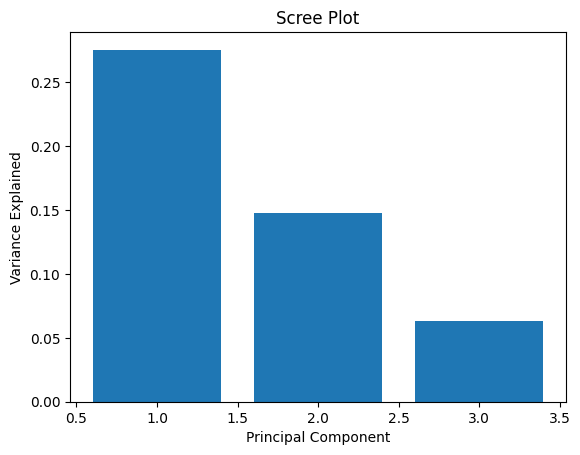

In [17]:
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.show()

# Decision Tree

In [ ]:
clf = DecisionTreeClassifier(random_state=42, max_depth=10)
clf.fit(X_images.reshape(len(X_images), -1), y_labels)
print("Score:", clf.score(X_images.reshape(len(X_images), -1), y_labels))

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=[f"pixel_{i}" for i in range(X_images.shape[1])])
plt.show()

In [ ]:
# train decision tree using KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for i, (train_index, val_index) in enumerate(kf.split(X_images)):
    print(f"Split {i}...")
    X_train, X_val = X_images[train_index], X_images[val_index]
    y_train, y_val = y_labels[train_index], y_labels[val_index]

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_val = X_val.reshape(X_val.shape[0], -1)

    clf = DecisionTreeClassifier(random_state=42, max_depth=10)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Accuracy:", acc)

    del X_train, X_val, y_train, y_val, clf, y_pred
    gc.collect()

Split 0...
Accuracy: 0.721875
Split 1...
Accuracy: 0.684375
Split 2...


# Neural Network

In [5]:
class COVIDDataset(Dataset):
    def __init__(self, image_paths, mask_paths, labels, transform_img=None, transform_mask=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.labels = labels
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(image_path).convert("RGB")
        
        # Load mask
        # Often masks are single-channel, so "L" is typical
        msk = Image.open(mask_path).convert("L")

        # Apply transforms, if defined
        if self.transform_img is not None:
            img = self.transform_img(img)
        if self.transform_mask is not None:
            msk = self.transform_mask(msk)

        return img, msk, label

In [ ]:
transform_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # shape (C, H, W), pixel values in [0,1]
])

# For masks, often we want just integer-coded segmentation:
transform_mask = transforms.Compose([
    transforms.Resize((224, 224)),  # or T.Resize((224,224), interpolation=...)
    transforms.ToTensor(),          # shape (1, H, W)
    # Might skip normalization for masks, or do something else
])

# Create the dataset
dataset = COVIDDataset(
    image_paths=all_image_paths,
    mask_paths=all_mask_paths,
    labels=all_labels,
    transform_img=transform_img,
    transform_mask=transform_mask
)

train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=all_labels,  # keep label distribution
    random_state=42
)

# Create Subsets for train/test
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()